## [Loading Required Libraries]() <a id="1" ></a>

In [1]:
!pip install rake-nltk

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=9044046f4bff6b956c5c57707a78615815c15d8a9088f6d712646d4912b754c5
  Stored in directory: /root/.cache/pip/wheels/ad/4f/6b/a5e7778f5c084d8b7c2c5fe9d37eb806f5ff5fee5e8ee17342
Successfully built rake-nltk


In [2]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.cluster import DBSCAN
from nltk.corpus import stopwords
from spacy.matcher import Matcher 
from collections import  Counter
import matplotlib.pyplot as plt
from spacy.tokens import Span 
import tensorflow_hub as hub
from rake_nltk import Rake
import tensorflow as tf
import pyLDAvis.gensim
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import pyLDAvis
import gensim
import spacy
import os
import gc

/opt/conda/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## <font size="5" color="blue">Exploratory Data Analysis</font><a id="1" ></a>

In [3]:
path="../input/CORD-19-research-challenge/"
all_sources=pd.read_csv(path+"metadata.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
all_sources.isna().sum()

cord_uid                 0
sha                  77267
source_x                 0
title                   30
doi                  29493
pmcid                71212
pubmed_id            32760
license                  0
abstract             29335
publish_time            12
authors               5003
journal               6895
mag_id              136067
who_covidence_id    115476
arxiv_id            134543
pdf_json_files       77267
pmc_json_files       89184
url                  10557
s2_id                27198
dtype: int64

###  <font color='red' size='3'>Distribution of title length</font>

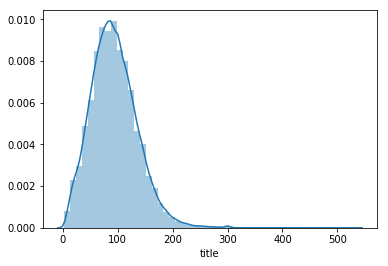

In [5]:
headline_length=all_sources['title'].str.len()
sns.distplot(headline_length)
plt.show()

### <font size='4' color='red'> Distribution of abstract length</font>

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


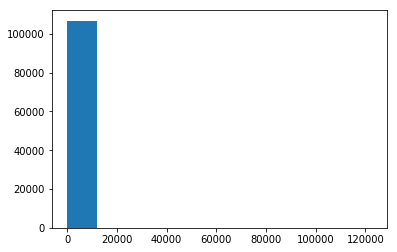

In [6]:
headline_length=all_sources['abstract'].str.len()
plt.hist(headline_length)
plt.show()

In [7]:
stop=set(stopwords.words('english'))

def build_list(df,col="title"):
    corpus=[]
    lem=WordNetLemmatizer()
    stop=set(stopwords.words('english'))
    new= df[col].dropna().str.split()
    new=new.values.tolist()
    corpus=[lem.lemmatize(word.lower()) for i in new for word in i if(word) not in stop]
    
    return corpus

### <font color='red' size="4">Which are most common words in title?</font>

In [8]:
corpus=build_list(all_sources)
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:10]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

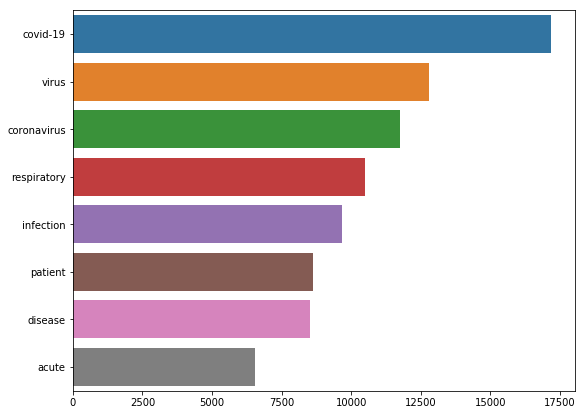

In [9]:
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)

### <font color='red' size='4'>Which are the most common words in abstracts ?</font>

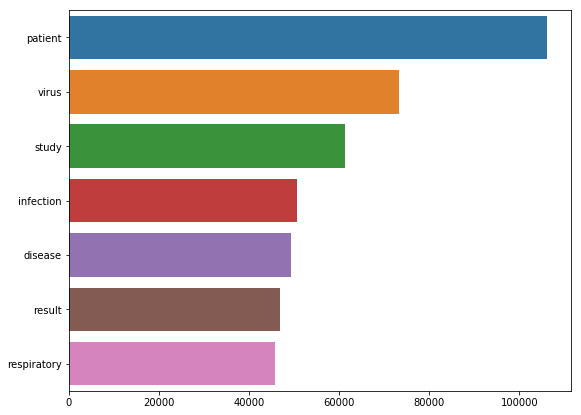

In [10]:
corpus=build_list(all_sources,"abstract")
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:10]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)

### <font size='4' color='red'>Which are the most common bi-grams in title?</font>

In [11]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]



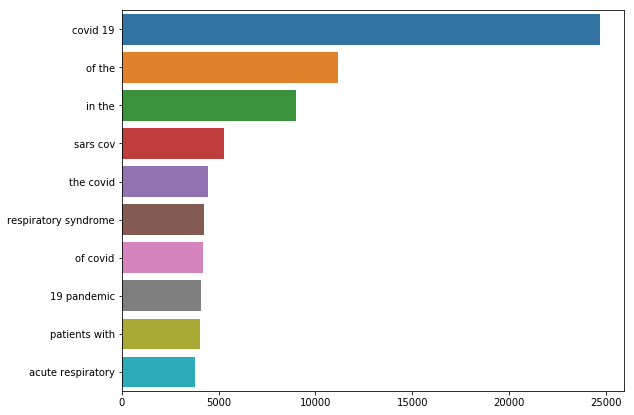

In [12]:
top_n_bigrams=get_top_ngram(all_sources['title'].dropna(),2)[:10]
x,y=map(list,zip(*top_n_bigrams))
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)

### <font size='4' color='red'> Which are the most common tri-grams in title?</font>

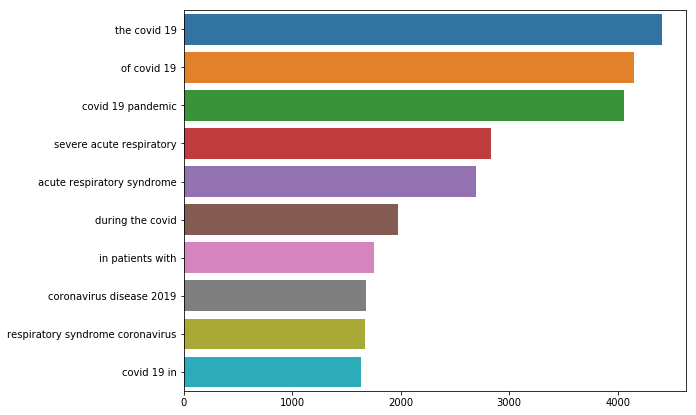

In [13]:
top_tri_grams=get_top_ngram(all_sources['title'].dropna(),n=3)
x,y=map(list,zip(*top_tri_grams))
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)

### <font color='red' size='4'> Topic modeling </font>

In [14]:
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['title'].dropna()[:5000]:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

In [15]:
corpus=preprocess_news(all_sources)
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]


In [16]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)

In [17]:
lda_model.show_topics()

[(0,
  '0.013*"Virus" + 0.006*"virus" + 0.005*"Novel" + 0.005*"Influenza" + 0.005*"cell" + 0.005*"Human" + 0.004*"Infection" + 0.003*"Health" + 0.003*"The" + 0.003*"RNA"'),
 (1,
  '0.012*"The" + 0.011*"virus" + 0.008*"influenza" + 0.008*"infection" + 0.005*"Respiratory" + 0.005*"Protein" + 0.004*"health" + 0.003*"role" + 0.003*"cell" + 0.003*"protein"'),
 (2,
  '0.009*"Virus" + 0.008*"Influenza" + 0.007*"respiratory" + 0.007*"acute" + 0.006*"virus" + 0.006*"influenza" + 0.006*"Infection" + 0.006*"infection" + 0.005*"syndrome" + 0.004*"cell"'),
 (3,
  '0.007*"Virus" + 0.006*"patient" + 0.006*"Cells" + 0.005*"Cell" + 0.005*"disease" + 0.004*"Human" + 0.004*"The" + 0.004*"viral" + 0.004*"human" + 0.004*"Viral"')]

### <font color='red' size='4'>Let's visualize the topic models</font>

In [18]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.109011 -0.092746       1        1  26.771091
2     -0.056002 -0.004383       2        1  25.996689
1     -0.102210 -0.033592       3        1  24.365112
3      0.049201  0.130721       4        1  22.867111, topic_info=     Category        Freq            Term       Total  loglift  logprob
89    Default  245.000000             The  245.000000  30.0000  30.0000
218   Default  191.000000       influenza  191.000000  29.0000  29.0000
132   Default  103.000000           acute  103.000000  28.0000  28.0000
134   Default  140.000000     respiratory  140.000000  27.0000  27.0000
136   Default   66.000000        syndrome   66.000000  26.0000  26.0000
...       ...         ...             ...         ...      ...      ...
573    Topic4   26.189451       Infection  171.760666  -0.4053  -6.0580
429    Topic4   23.814289         Protein  119.098038  -0.1342  -6.1530
939    Topic4   20.983458         vaccine   58.642662   0.4477  -6.2796
1107   Topic4   20.574371  Identification   64.572571   0.3317  -6.2993
1679   Topic4   19.963299            Mice   49.665291   0.5641  -6.3294

[316 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
12665      1  0.970428    2019
9237       4  0.864687   ALV-J
3355       1  0.926446  Active
461        2  0.584237   Acute
461        3  0.217390   Acute
...      ...       ...     ...
309        4  0.446050   viral
56         1  0.232470   virus
56         2  0.251319   virus
56         3  0.395828   virus
56         4  0.119377   virus

[524 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [19]:
del corpus,top_n_bigrams,lda_model,bow_corpus,top_tri_grams
gc.collect()

310

## <font size="5" color="blue">Find Similar Papers</font><a id="2"></a>

<font color='red' size='4'>Method 1: Using Universal sentence Encoder</font>
- Done using Universal Sentence encoder and consine similarity.

In [20]:

def prepare_similarity(vectors):
    similarity=cosine_similarity(vectors)
    return similarity

def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [(i,sentence_list[i]) for i in indices]


In [21]:
module_url = "../input/universalsentenceencoderlarge4" 
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load(module_url)

In [22]:


titles=all_sources['title'].fillna("Unknown")
embed_vectors=embed(titles[:100].values)['outputs'].numpy()
sentence_list=titles.values.tolist()
sentence=titles.iloc[5]
print("Find similar research papers for :")
print(sentence)

similarity_matrix=prepare_similarity(embed_vectors)
similar=get_top_similar(sentence,sentence_list,similarity_matrix,6)



Find similar research papers for :
Sequence requirements for RNA strand transfer during nidovirus discontinuous subgenomic RNA synthesis


In [23]:
for sentence in similar:
    print(sentence)
    print("\n")

(5, 'Sequence requirements for RNA strand transfer during nidovirus discontinuous subgenomic RNA synthesis')


(9, 'Discontinuous and non-discontinuous subgenomic RNA transcription in a nidovirus')


(93, 'Species-independent detection of RNA virus by representational difference analysis using non-ribosomal hexanucleotides for reverse transcription')


(57, 'The Structure of a Rigorously Conserved RNA Element within the SARS Virus Genome')


(46, 'Mutations in the IGF-II pathway that confer resistance to lytic reovirus infection')


(28, 'Heterogeneous nuclear ribonucleoprotein A1 regulates RNA synthesis of a cytoplasmic virus')




In [24]:
del embed_vectors,sentence_list,similarity_matrix
gc.collect()

3013

- <font color='red' size='4'>Method 2 : Cluster articles using DBSCAN</font>

In [25]:
nlp=spacy.load('en_core_web_sm')
sent_vecs={}
docs=[]

for i in tqdm(all_sources['title'].fillna('unknown')[:1000]):
    doc=nlp((i)) 
    docs.append(doc)
    sent_vecs.update({i :doc.vector})




100%|██████████| 1000/1000 [00:12<00:00, 81.64it/s]


In [26]:
sentences=list(sent_vecs.keys())
vectors=list(sent_vecs.values())


In [27]:
x=np.array(vectors)
dbscan=DBSCAN(eps=0.08, min_samples=2,metric='cosine' ).fit(x)
df_cluster=pd.DataFrame({'sentences':sentences,'label':dbscan.labels_})

In [28]:
df_cluster.label.unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18])

- `-1` label indicates that the sentence does not belong to any cluster.

#### Some example clusters :

In [29]:
df_cluster[(df_cluster['label']==0)].head()

,sentences,label
11,The 21st International Symposium on Intensive ...,0
35,8th Annual Toronto Critical Care Medicine Symp...,0
259,26th International Symposium on Intensive Care...,0


In [30]:
df_cluster[(df_cluster['label']==1)].head()

,sentences,label
85,Recombination Every Day: Abundant Recombinatio...,1
367,No Effect of a Homeopathic Preparation on Neon...,1


## <font size='5' color='blue'>Mining Related articles</font><a id='4'></a>

### What is known about transmission, incubation, and environmental stability?

- Seasonality of transmission.
- Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).
- Natural history of the virus and shedding of it from an infected person
- Implementation of diagnostics and products to improve clinical processes
- Disease models, including animal models for infection, disease and transmission
- Tools and studies to monitor phenotypic change and potential adaptation of the virus
- Immune response and immunity
- Role of the environment in transmission

## <font size='4' color='red'>My Approach</font>
- First append articles from all the sources
- Choose a subtask from above task
- Find related articles
- Form a list of abstrat from these articles
- Then do keyword extraction to get important keyowords from these research papers.

In [31]:
path="../input/cord-19-eda-parse-json-and-generate-clean-csv/"


In [32]:
clean_comm=pd.read_csv(path+"clean_comm_use.csv",nrows=5000)
clean_comm['source']='clean_comm'
#clean_pmc=pd.read_csv(path+"clean_pmc.csv")
#clean_pmc['source']='clean_pmc'
biox = pd.read_csv(path+"biorxiv_clean.csv")
biox['source']='biorx'

all_articles=pd.concat([biox,clean_comm])

In [33]:
del biox,clean_comm
gc.collect()

0

In [34]:
all_articles.shape

(6625, 10)

- Define the tasks 

In [35]:
tasks=["What is known about transmission, incubation, and environmental stability",
      "What do we know about COVID-19 risk factors",
      "What do we know about virus genetics, origin, and evolution",
      "What do we know about vaccines and therapeutics",
      "What do we know about non-pharmaceutical interventions",
      "What do we know about diagnostics and surveillance",
      "What has been published about ethical and social science considerations",
      "Role of the environment in transmission",
      "Range of incubation periods for the disease in humans",
      "Prevalence of asymptomatic shedding and transmission",
      "Seasonality of transmission",
      "Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic)",
      "Susceptibility of populations",
      "Public health mitigation measures that could be effective for control",
      "Transmission dynamics of the virus",
      "Evidence that livestock could be infected",
      "Socioeconomic and behavioral risk factors for this spill-over",
      "Sustainable risk reduction strategies",
      "Resources to support skilled nursing facilities and long term care facilities",
      "Mobilization of surge medical staff to address shortages in overwhelmed communities"]

In [36]:
task_df=pd.DataFrame({'title':tasks,'source':'task'})

In [37]:
task_df.head()

,title,source
0,"What is known about transmission, incubation, ...",task
1,What do we know about COVID-19 risk factors,task
2,"What do we know about virus genetics, origin, ...",task
3,What do we know about vaccines and therapeutics,task
4,What do we know about non-pharmaceutical inter...,task


In [38]:
all_articles=pd.concat([all_articles,task_df])
all_articles.fillna("Unknown",inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


- Find related research papers using  USE method.

In [39]:
sentence_list=all_articles.title.values.tolist()
embed_vectors=embed(sentence_list)['outputs'].numpy()
similarity_matrix=prepare_similarity(embed_vectors)


In [40]:
sentence= "Role of the environment in transmission"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,10)

In [41]:
for sent in similar:
    print(sent[1])

Role of the environment in transmission
Aerobiology and Its Role in the Transmission of Infectious Diseases
Effects of temperature on COVID-19 transmission
What is known about transmission, incubation, and environmental stability
The role of absolute humidity on transmission rates of the COVID-19 outbreak
Transmission dynamics of the virus
Temperature dependence of COVID-19 transmission
Roles of meteorological conditions in COVID-19 transmission on a worldwide scale
Role of Oct4 in the early embryo development
Role of fomites in SARS transmission during the largest hospital outbreak in Hong Kong


- Clean and store abstracts from related articles.

In [42]:
ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])

In [43]:
import re
def clean(txt):
    txt=re.sub(r'\n','',txt)
    txt=re.sub(r'\([^()]*\)','',txt)
    txt=re.sub(r'https?:\S+\sdoi','',txt)
    return txt

In [44]:
texts=list(map(clean,texts))
text_list=' '.join(texts)
#text_list=word_tokenize(text_list)


- Now we can proceed to see two different `keyword extraction methods`.

## <font size='5' color='blue'> Keyword Extraction</font><a id='3'></a>



Keyword extraction is the automated process of extracting the most relevant words and expressions from text.Keyword extraction (also known as keyword detection or keyword analysis) is a text analysis technique that consists of automatically extracting the most important words and expressions in a text. It helps summarize the content of a text and recognize the main topics which are being discussed. 

### <font size='3' color='red'>Method 2: PytextRank</font>

In [47]:
!pip install pytextrank

In [48]:
import logging
import pytextrank
import spacy
import sys

In [49]:

nlp = spacy.load("en_core_web_sm")

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger("PyTR")

# add PyTextRank into the spaCy pipeline

tr = pytextrank.TextRank(logger=None)
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

# parse the document

doc = nlp(text_list)

print("pipeline", nlp.pipe_names)
print("elapsed time: {} ms".format(tr.elapsed_time))


# examine the top-ranked phrases in the document



pipeline ['tagger', 'parser', 'ner', 'textrank']
elapsed time: 225.2941131591797 ms


In [50]:
for phrase in doc._.phrases[:10]:
    print("{}".format(phrase.text))
    #print(phrase.chunks)

airborne infectious diseases
fomite transmission
transmission
different countries
unknown unknown unknown abstractthe recent coronavirus pandemic
many countries
outbreak control
infectious diseases
severe acute respiratory syndrome coronavirus
critical role


## <font size='5' color='blue'>Knowledge Graph</font><a id='5'></a>

- Next,we will try and draw a knowledge graph from the related papers we found.

In [51]:
import spacy
nlp=spacy.load('en_core_web_sm')

In [52]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

  #############################################################
  
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
          # check: token is a compound word or not
          if tok.dep_ == "compound":
            prefix = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                   prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
              modifier = prv_tok_text + " "+ tok.text

          ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

          ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

          ## chunk 5  
          # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
  #############################################################

    return [ent1.strip(), ent2.strip()]

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

### <font size='3' color='red'>Question : What is the Role of the environment in transmission?</font>

- We will prepare a dataframe that contains,subject,relation and object from these abstracts to plot the knowledge graph.


In [ ]:
def prepare_df(text_list):
    doc=nlp(text_list)
    df=pd.DataFrame()
    for sent in list(doc.sents):
        sub,obj = get_entities(str(sent))
        relation= get_relation(str(sent))

        if ((len(relation)>2) & (len(sub)>2) &(len(obj)>2)):
            df=df.append({'subject':sub,'relation':relation,'object':obj},ignore_index=True)

    return df

In [ ]:
df = prepare_df(text_list[24:])
df.head()

In [ ]:

def draw_kg(pairs,c1='red',c2='blue',c3='orange'):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
  
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(50, 40), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color=c1,
        edgecolors=c2,
        node_color=c3,
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

In [ ]:
draw_kg(df)

### <font size='3' color='red'>What is known about transmission, incubation, and environmental stability? </font>

- Get similar articles.

In [ ]:
sentence= "What is known about transmission, incubation, and environmental stability"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)


- Prepare the abstract and title

In [ ]:
ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])

In [ ]:
texts=list(map(clean,texts))
text_list=' '.join(texts)

- Find the subject,object and relations and plot the KG.

In [ ]:
df = prepare_df(text_list)
draw_kg(df)

### <font size='3' color='red'>What do we know about COVID-19 risk factors?</font>

In [ ]:
sentence= "What do we know about COVID-19 risk factors"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,8)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>What do we know about virus genetics, origin, and evolution?
</font>

In [ ]:
sentence= "What do we know about virus genetics, origin, and evolution"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>What do we know about vaccines and therapeutic?</font>

In [ ]:
sentence= "What do we know about vaccines and therapeutics"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>What is the Role of the environment in transmission</font>

In [ ]:
sentence= "Role of the environment in transmission"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

<font size='3' color='red'>What do we know about non-pharmaceutical interventions?</font>


In [ ]:
sentence="What do we know about non-pharmaceutical interventions"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>What has been published about ethical and social science considerations?</font>


In [ ]:
sentence= "What has been published about ethical and social science considerations"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>What do we know about diagnostics and surveillance?</font>


In [ ]:
sentence="What do we know about diagnostics and surveillance"

similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

<font size='3' color='red'>What is known about the Range of incubation periods for the disease in humans?</font>

In [ ]:
sentence="Range of incubation periods for the disease in humans"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

<font size='3' color='red'>What is known about Role of the environment in transmission?</font>

In [ ]:
sentence="Role of the environment in transmission"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

<font size='3' color='red'>What is known about Seasonality of transmission</font>

In [ ]:
sentence="Seasonality of transmission"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

* <font size='3' color='red'>What has been published about Prevalence of asymptomatic shedding and transmission</font>

In [ ]:
sentence="Prevalence of asymptomatic shedding and transmission"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

<font size='3' color='red'>What is known about the Susceptibility of populations?</font>

In [ ]:


sentence="Susceptibility of populations"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

In [ ]:
df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

<font size='3' color='red'>What is known about Public health mitigation measures that could be effective for control</font>

In [ ]:
sentence="Public health mitigation measures that could be effective for control"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

![](http://)<font size='3' color='red'>What is known about the Transmission dynamics of the virus</font>

In [ ]:
sentence= "Transmission dynamics of the virus"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>Do we have any Evidence that livestock could be infected?</font>


In [ ]:
sentence= "Evidence that livestock could be infected"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>What is known about Socioeconomic and behavioral risk factors for this spill-over</font>


In [ ]:
sentence= "Socioeconomic and behavioral risk factors for this spill-over"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>What are the Sustainable risk reduction strategies?</font>


In [ ]:
sentence= "Sustainable risk reduction strategies"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

## <font size='3' color='red'>Resources to support skilled nursing facilities and long term care facilities</font>

In [ ]:
sentence= "Resources to support skilled nursing facilities and long term care facilities"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')

### <font size='3' color='red'>Mobilization of surge medical staff to address shortages in overwhelmed communities</font>

In [ ]:
sentence= "Mobilization of surge medical staff to address shortages in overwhelmed communities"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
texts=list(map(clean,texts))
text_list=' '.join(texts)

df = prepare_df(text_list)
draw_kg(df,c1='blue',c2='pink',c3='green')